In [1]:
# Importing necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, ReLU, Input, LeakyReLU

2024-08-22 06:05:26.094752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 06:05:26.094894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 06:05:26.252704: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load Dataset

In [3]:
def load_colored_faces(folder_path, target_size=(224, 224)):
    images = []
    labels = []
        
    if os.path.isdir(folder_path):
        # Sort the list of filenames
        filenames = sorted(os.listdir(folder_path))
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, target_size)  # Resize to target size
                
                img_array = img / 255.0  # Normalize pixel values to be between 0 and 1
                images.append(img_array)
                labels.append(0)  # Assigning a label (currently set to 0, modify as needed)
            
    return np.array(images), np.array(labels)

def load_pencil_faces(folder_path, target_size=(224, 224)):
    images = []
    labels = []
        
    if os.path.isdir(folder_path):
        # Sort the list of filenames
        filenames = sorted(os.listdir(folder_path))
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            if img is not None:
                img = cv2.resize(img, target_size)  # Resize to target size
                
                img_array = img / 255.0  # Normalize pixel values to be between 0 and 1
                images.append(img_array)
                labels.append(1)  # Assigning a label (currently set to 1, modify as needed)
                
    return np.array(images), np.array(labels)



In [4]:
color_faces,_ = load_colored_faces('/kaggle/input/rgb-faces-vs-pencil-faces/Faces_RGB_vs_Pencil/RGB_Faces')
pencil_faces,_ = load_pencil_faces('/kaggle/input/rgb-faces-vs-pencil-faces/Faces_RGB_vs_Pencil/Pencil_Faces')

In [5]:
print(color_faces.shape,pencil_faces.shape)

(1081, 224, 224, 3) (1081, 224, 224)


### Visualization

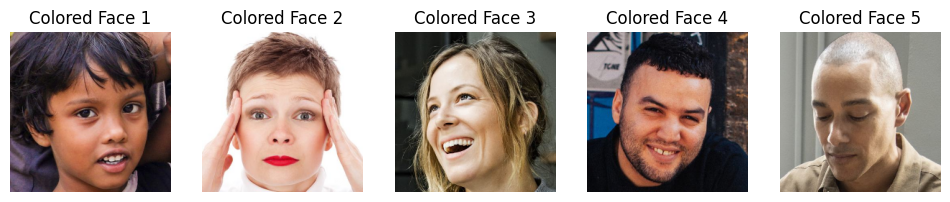

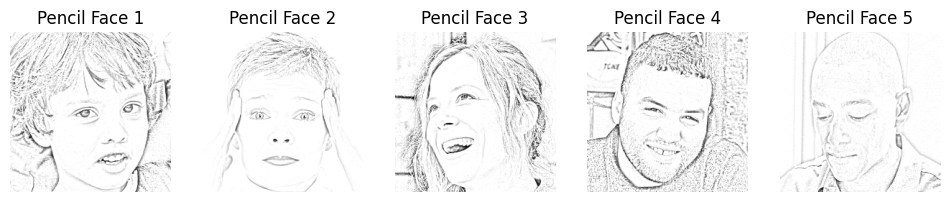

In [6]:
# Display the first 5 images from the dataset
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(color_faces[i])
    plt.title(f"Colored Face {i + 1}")
    plt.axis('off')

plt.show()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(pencil_faces[i],cmap='gray')
    plt.title(f"Pencil Face {i + 1}")
    plt.axis('off')

plt.show()

In [7]:
# Expand the dimensions of pencil_faces to make it 3D
pencil_face_three_dim = np.expand_dims(pencil_faces, axis=-1)

# Tile the 3D array along the third dimension to create a 3-channel image
# This is done to match the format of the colored faces (3 channels for RGB)
pencil_face_three_dim = np.tile(pencil_face_three_dim, (1, 1, 3))

In [8]:
pencil_faces = pencil_face_three_dim

In [9]:
print(pencil_faces.shape)
print(color_faces.shape)

(1081, 224, 224, 3)
(1081, 224, 224, 3)


### Split Dataset

In [10]:
x_train_color,x_test_color,x_train_pencil,x_test_pencil=train_test_split(color_faces,pencil_faces,test_size=0.2,random_state=100,shuffle= True)

In [11]:
print(x_train_color.shape,x_train_pencil.shape)
print(x_test_color.shape,x_test_pencil.shape)

(864, 224, 224, 3) (864, 224, 224, 3)
(217, 224, 224, 3) (217, 224, 224, 3)


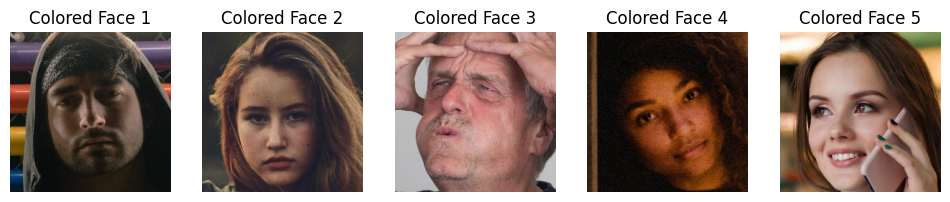

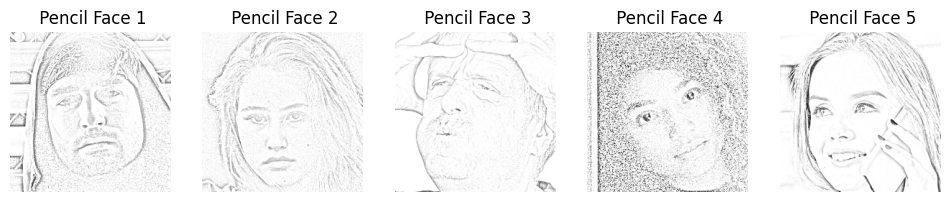

In [12]:
# Display the first 5 images from training dataset
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train_color[i])
    plt.title(f"Colored Face {i + 1}")
    plt.axis('off')

plt.show()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train_pencil[i],cmap='gray')
    plt.title(f" Pencil Face {i + 1}")
    plt.axis('off')
plt.show()

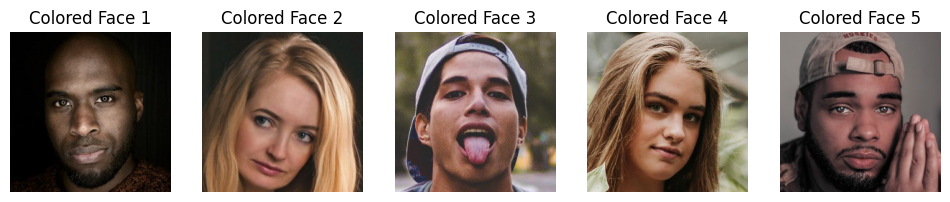

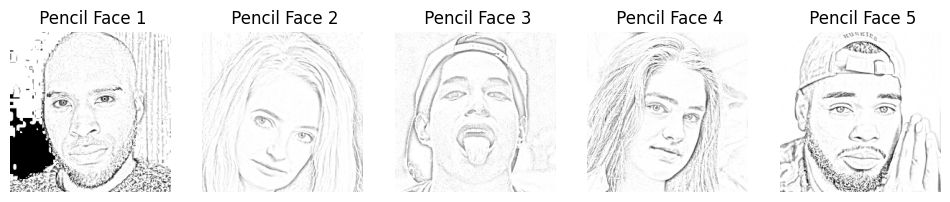

In [13]:
# Display the first 5 images from testing dataset
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test_color[i])
    plt.title(f"Colored Face {i + 1}")
    plt.axis('off')

plt.show()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test_pencil[i],cmap='gray')
    plt.title(f" Pencil Face {i + 1}")
    plt.axis('off')
plt.show()

### Building U Net Model

In [ ]:
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, kernel_size=3, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, kernel_size=2, strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 30)
    s3, p3 = encoder_block(p2, 40)
    s4, p4 = encoder_block(p3, 50)

    # Bottleneck
    b1 = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b1, s4, 50)
    d2 = decoder_block(d1, s3, 40)
    d3 = decoder_block(d2, s2, 30)
    d4 = decoder_block(d3, s1, 64)

    # Output layer
    outputs = layers.Conv2D(3, kernel_size=1, activation='sigmoid')(d4)

    model = models.Model(inputs, outputs, name="U-Net")
    return model

In [14]:
# Define the input shape
input_shape = (224, 224, 3)

# Build the U-Net model
unet_model = build_unet(input_shape)

# Compile the model
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
unet_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 224, 224,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 224, 224,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     17,310 │ max_pooling2d[0]… │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      8,130 │ leaky_re_lu_2[0]… │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 112, 112,  │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     10,840 │ max_pooling2d_1[… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 56, 56,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     14,440 │ leaky_re_lu_4[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 56, 56,    │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ leaky_re_lu_5[0]… │
│ (MaxPooling2D)      │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     18,050 │ max_pooling2d_2[

 Total params: 3,089,979 (11.79 MB)

 Trainable params: 3,089,979 (11.79 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [18]:
# Train  U-Net model and get the history
history = unet_model.fit(x_train_color, x_train_pencil, epochs=20, batch_size=32)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 639s 24s/step - accuracy: 0.2188 - loss: 0.2199
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 621s 23s/step - accuracy: 0.7063 - loss: 0.1953
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 616s 23s/step - accuracy: 0.3622 - loss: 0.1875
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 619s 23s/step - accuracy: 0.5079 - loss: 0.1649
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 623s 23s/step - accuracy: 0.3229 - loss: 0.1546
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 620s 23s/step - accuracy: 0.2922 - loss: 0.1535
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 619s 23s/step - accuracy: 0.3457 - loss: 0.1491
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 622s 23s/step - accuracy: 0.4617 - loss: 0.1440
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 620s 23s/step - accuracy: 0.3129 - loss: 0.1448
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 620s 23s/step - accuracy: 0.4881 - loss: 0.1398
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 620s 23s/step - accuracy: 0.3891 - loss: 0.1428
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 620s 23s/step

### Testing

In [20]:
pred_pencil_faces = unet_model.predict(x_test_color)

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step


In [29]:
unet_model.evaluate(x_test_pencil,pred_pencil_faces)

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.5593 - loss: 0.1670


[0.16562728583812714, 0.5651302933692932]

Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

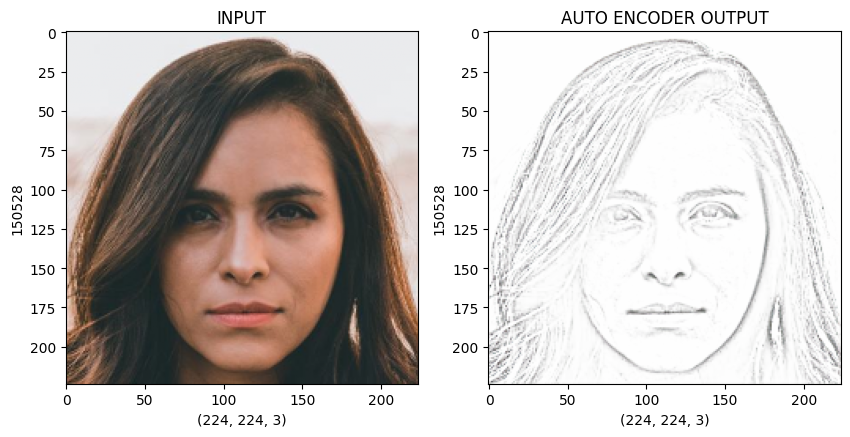

In [21]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
prediction_img_number = 130

Original_Img = x_test_color[prediction_img_number]
Predict_Image_AE = pred_pencil_faces[prediction_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("INPUT")
axis[1].imshow(Predict_Image_AE,cmap='gray')
axis[1].set_xlabel(Predict_Image_AE.shape)
axis[1].set_ylabel(Predict_Image_AE.size)
axis[1].set_title("AUTO ENCODER OUTPUT")

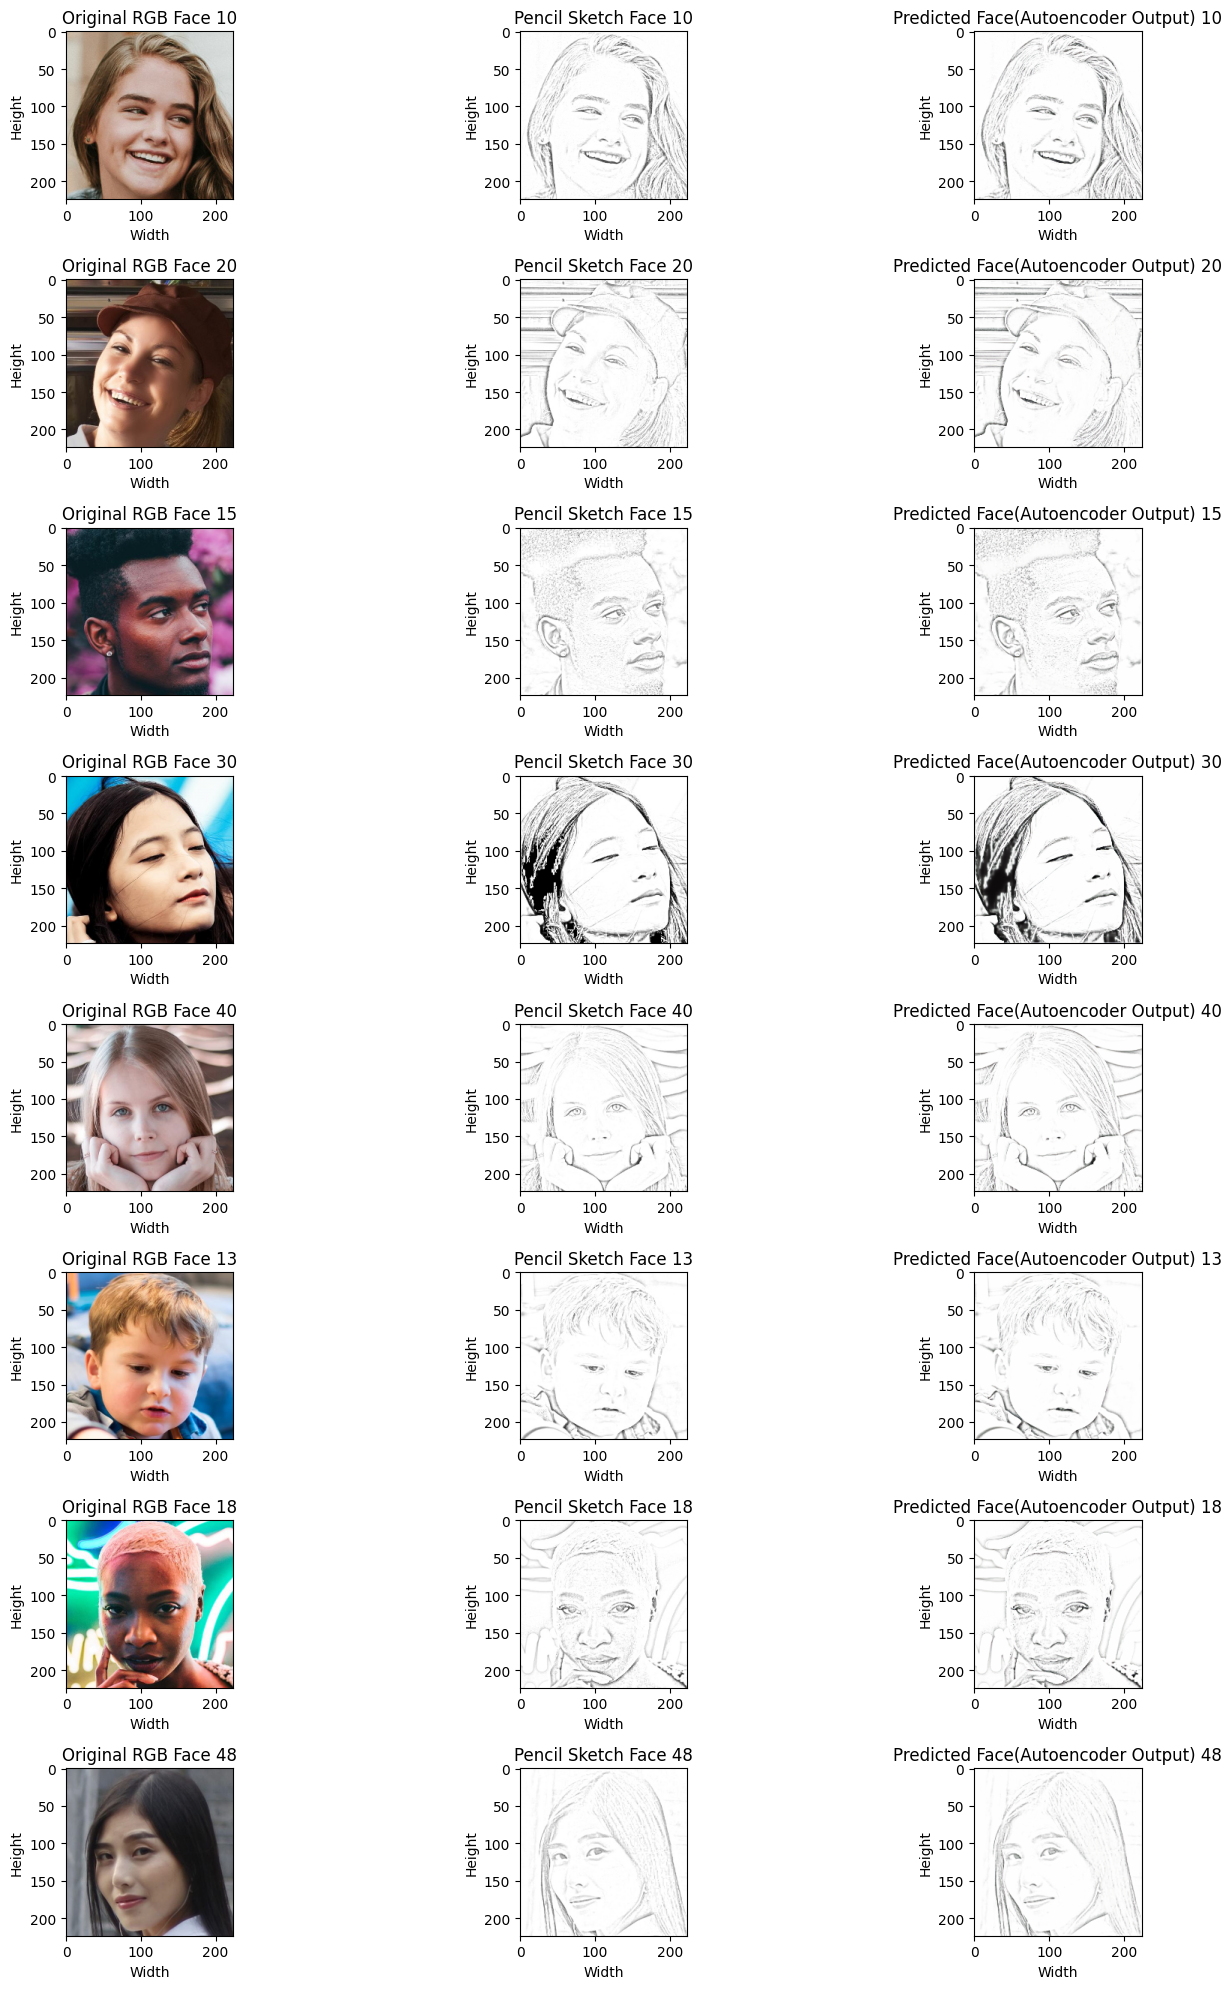

In [27]:
# Select image numbers for visualization
prediction_img_numbers = [10, 20, 15, 30, 40,13,18,48]

# Create a subplot figure with 5 rows and 3 columns
fig, axes = plt.subplots(8, 3, figsize=(15, 20))

# Loop over each selected image number
for i, img_number in enumerate(prediction_img_numbers):
    # Original RGB image
    axes[i, 0].imshow(x_test_color[img_number])
    axes[i, 0].set_xlabel("Width")
    axes[i, 0].set_ylabel("Height")
    axes[i, 0].set_title(f"Original RGB Face {img_number}")
    
    # Pencil sketch image
    axes[i, 1].imshow(x_test_pencil[img_number], cmap='gray')
    axes[i, 1].set_xlabel("Width")
    axes[i, 1].set_ylabel("Height")
    axes[i, 1].set_title(f"Pencil Sketch Face {img_number}")
    
    # Predicted image from autoencoder
    axes[i, 2].imshow(pred_pencil_faces[img_number], cmap='gray')
    axes[i, 2].set_xlabel("Width")
    axes[i, 2].set_ylabel("Height")
    axes[i, 2].set_title(f"Predicted Face(Autoencoder Output) {img_number}")

plt.tight_layout()
plt.show()
